# Build Time-networks based on year of first PMID for an edge

We will build networks representing the state of knowledge at different timepoints.  This will be done by filtering edges by date, using the PMID associated with the earliest timepoint for each given edge.

In [1]:
import os
import pickle
import pandas as pd
from tqdm import tqdm, tqdm_pandas

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

import sys
sys.path.append('../../hetnet-ml/src')
import graph_tools as gt

## Build a final ID to year map

Each map came from a different source, so make sure they are consistent in type

In [2]:
nlm = pickle.load(open('../data/pmid_to_year_NLM.pkl', 'rb'))
pmc = pickle.load(open('../data/pmid_to_year_PMC.pkl', 'rb'))
eur = pickle.load(open('../data/pmid_to_year_Eur.pkl', 'rb'))
ebi = pickle.load(open('../data/pmid_to_year_EBI.pkl', 'rb'))

There may be type differences between these maps, lets check.  
Ideally we want, `key=str: value=int`.

In [3]:
key = list(nlm.keys())[0]
value = nlm[key]
print('{!r}: {!r}'.format(key, value))

'8496615': '1993'


`{str: str}`

In [4]:
key = list(pmc.keys())[0]
value = pmc[key]
print('{!r}: {!r}'.format(key, value))

'10834904': 2000


`{str: int}`

In [5]:
key = list(eur.keys())[0]
value = eur[key]
print('{!r}: {!r}'.format(key, value))

'26788178': '2015'


`{str: str}`

In [6]:
key = list(ebi.keys())[0]
value = ebi[key]
print('{!r}: {!r}'.format(key, value))

'26726691': '2016-01-05'


`{str: str}` with year formatted as `YYYY-MM-DD`

#### Reformatting the maps

`{str: int}` with only the year is the most useful for our purposes, so format all of these maps to this schema

In [7]:
for k, v in tqdm(nlm.items()):
    nlm[k] = int(v)

100%|██████████| 27836723/27836723 [00:44<00:00, 631862.26it/s]


In [8]:
for k, v in tqdm(eur.items()):
    eur[k] = int(v)

100%|██████████| 3561213/3561213 [00:04<00:00, 833546.18it/s]


In [9]:
for k, v in tqdm(ebi.items()):
    ebi[k] = int(v.split('-')[0])

100%|██████████| 7937/7937 [00:00<00:00, 572065.21it/s]


In [10]:
# order of importance right to left. (pmc values will replace all others)
id_to_year = {**eur, **nlm, **ebi, **pmc}
id_to_year = {str(k): v for k, v in id_to_year.items()}

## Bring in the nodes and edges files

In [11]:
tqdm.pandas()

In [12]:
nodes = gt.remove_colons(pd.read_csv('../data/nodes_VER31_R_cons_6_metanode.csv'))
nodes.head(2)

,id,name,label,id_source
0,C0229664,peripheral blood,Anatomy,UMLS
1,C0545822,"Esophagus, stomach and duodenum",Anatomy,UMLS


In [13]:
edges = gt.remove_colons(pd.read_csv('../data/edges_VER31_R_cons_6_metanode.csv'))
edges['pmids'] = edges['pmids'].progress_apply(eval)
edges.head(2)

100%|██████████| 7784275/7784275 [02:27<00:00, 52618.01it/s]


,start_id,end_id,type,pmids,n_pmids
0,D010447,D010519,AFFECTS_CDafA,"{10920248, 19040577}",2
1,D008239,D022781,AFFECTS_CDafA,"{496661, 21106925, 6696070}",3


## Edge type breakdown by PMID count in final network

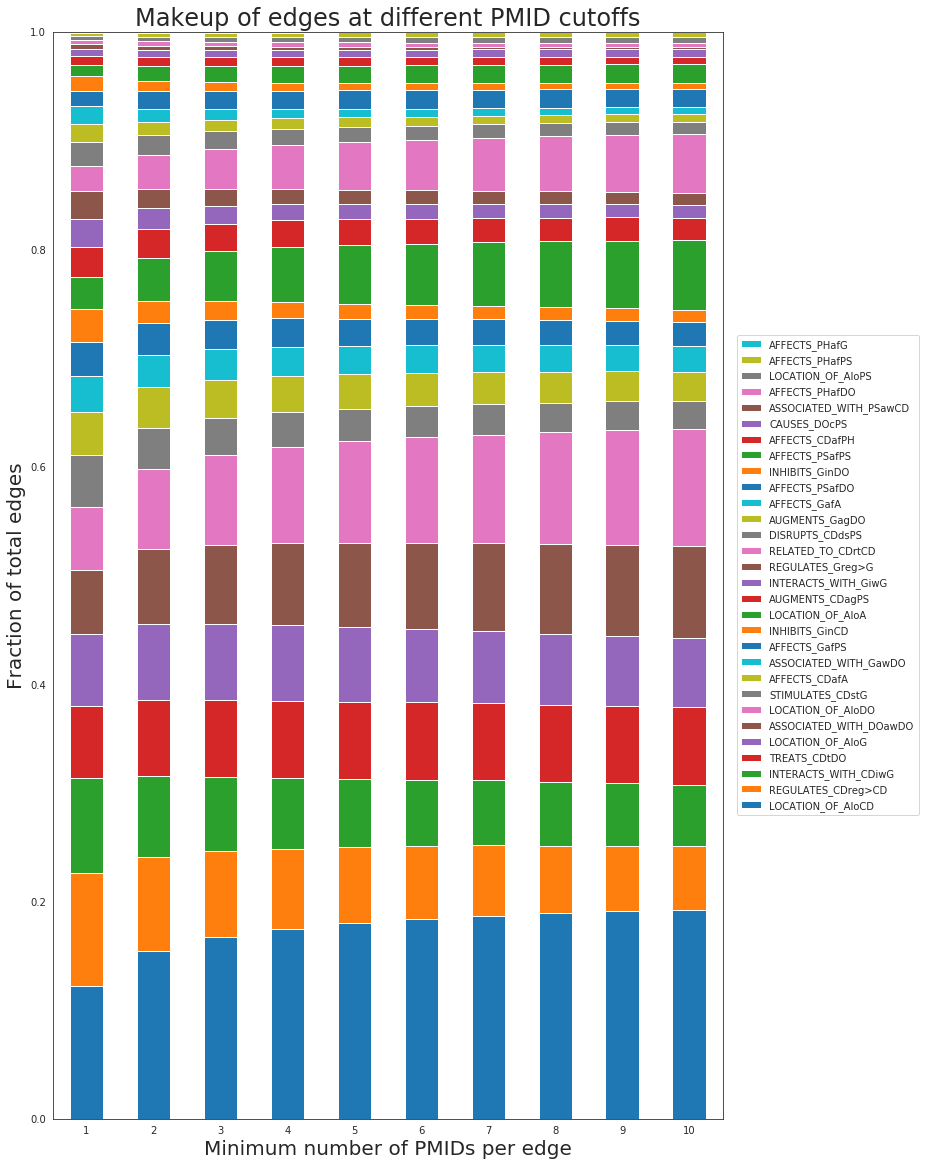

In [14]:
frame = pd.DataFrame()
for i in range(10):

    to_plot = edges.query('n_pmids > @i')['type'].value_counts()
    to_plot = to_plot / to_plot.sum()
    frame[i+1] = to_plot
    
    
fig = frame.T.plot.bar(stacked=True, figsize=(12, 20))
handels, labels = fig.axes.get_legend_handles_labels()
plt.legend(handels[::-1], labels[::-1], loc=7, bbox_to_anchor=(1.3, 0.5))
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.title('Makeup of edges at different PMID cutoffs', size=24)
plt.xlabel('Minimum number of PMIDs per edge', size=20)
plt.ylabel('Fraction of total edges', size = 20);

## Now apply the ID to Year Map

In [15]:
# turn pmids into a list so order is preserved
edges['pmids'] = edges['pmids'].apply(list)
edges.head(2)

,start_id,end_id,type,pmids,n_pmids
0,D010447,D010519,AFFECTS_CDafA,"[10920248, 19040577]",2
1,D008239,D022781,AFFECTS_CDafA,"[496661, 21106925, 6696070]",3


In [16]:
# Ideally just want minimum year for a given edge, so supplying 9999 for not found pmids will
# allow min() to be used on the resulting list.
edges['pub_years'] = edges['pmids'].progress_apply(lambda pmids: [id_to_year.get(str(p), 9999) for p in pmids])
edges.head(2)

100%|██████████| 7784275/7784275 [01:09<00:00, 112528.28it/s]


,start_id,end_id,type,pmids,n_pmids,pub_years
0,D010447,D010519,AFFECTS_CDafA,"[10920248, 19040577]",2,"[2000, 2008]"
1,D008239,D022781,AFFECTS_CDafA,"[496661, 21106925, 6696070]",3,"[1979, 2010, 1984]"


In [17]:
edges['first_pub'] = edges['pub_years'].progress_apply(min)
edges.head(2)

100%|██████████| 7784275/7784275 [00:22<00:00, 351991.19it/s]


,start_id,end_id,type,pmids,n_pmids,pub_years,first_pub
0,D010447,D010519,AFFECTS_CDafA,"[10920248, 19040577]",2,"[2000, 2008]",2000
1,D008239,D022781,AFFECTS_CDafA,"[496661, 21106925, 6696070]",3,"[1979, 2010, 1984]",1979


## Now the get the dates from the gold standard.

In [18]:
indications = pd.read_csv('../data/indications_nodemerge.csv')
indications.head(2)

,id,struct_id,concept_id,relationship_name,disease_name,umls_cui,snomed_full_name,cui_semantic_type,snomed_conceptid,compound_name,compound_semmed_id,disease_semmed_id,approval_date,approval_year
0,173432,965,40249340,indication,Malignant tumor of breast,C0006142,Malignant tumor of breast,T191,254837009.0,drostanolone propionate,C007561,DOID:1612,NaN,NaN
1,173433,318,21000716,indication,Gout,C0018099,Gout,T047,90560007.0,benzbromarone,D001553,DOID:13189,NaN,NaN


In [19]:
len(indications)

8279

Some NA values in the date, won't be useul for this analysis so just drop them

In [20]:
indications.dropna(subset=['approval_year'], inplace=True)
indications['approval_year'] = indications['approval_year'].astype(int)

In [21]:
len(indications)

7100

## Filter nodes and edges by year to build the network

In [22]:
base_dir = '../data/time_networks-6_metanode'

In [23]:
def get_year_category(diff):
    if diff > 20:
        return '20+ After'
    elif diff >= 15 and diff < 20:
        return '15-20 After'
    elif diff >= 10 and diff < 15:
        return '10-15 After'
    elif diff >= 5 and diff < 10:
        return '5-10 After'
    elif diff >= 0 and diff < 5:
        return '0-5 After'
    elif diff >= -5 and diff < 0:
        return '0-5 Before'
    elif diff >= -10 and diff < -5:
        return '5-10 Before'
    elif diff >= -15 and diff < -10:
        return '10-15 Before'
    elif diff >= -20 and diff < -15:
        return '15-20 Before'
    elif diff < -20:
        return '20+ Before'

In [24]:
def plot_figure(indications, year, out_dir):
    
    order = ['20+ Before',
         '15-20 Before',
         '10-15 Before',
         '5-10 Before',
         '0-5 Before',
         '0-5 After',
         '5-10 After',
         '10-15 After',
         '15-20 After',
         '20+ After']
    
    
    plt.clf()
    plt.figure(figsize=(6, 4.5))

    f = sns.countplot(x='year_cat', data=indications, order=order)
    
    plt.ylabel('Count')
    plt.xlabel('Years from approval and {}'.format(year))
    plt.xticks(rotation=45)

    xlim = f.axes.get_xlim()
    x_mid = (xlim[1] + xlim[0]) / 2

    tick_diff = f.get_yticks()[1] - f.get_yticks()[0]
    y_height = f.get_yticks()[-2] - tick_diff/5 

    plt.text(3*x_mid/2, y_height, 'Total indications:\n          {}'.format(len(indications)))


    plt.title('Distribution of approval years for {}'.format(year))
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'ind-distribution.png'));

  0%|          | 0/15 [00:00<?, ?it/s]

Year: 1950
IDs: 8,760
Nodes: 8,760
Edges: 32,132
Indications: 702




  7%|▋         | 1/15 [00:04<01:01,  4.41s/it]

Year: 1955
IDs: 12,789
Nodes: 12,789
Edges: 62,045
Indications: 1,121




 13%|█▎        | 2/15 [00:08<00:54,  4.17s/it]

Year: 1960
IDs: 16,327
Nodes: 16,327
Edges: 92,536
Indications: 1,756




 20%|██        | 3/15 [00:12<00:52,  4.35s/it]

Year: 1965
IDs: 20,631
Nodes: 20,631
Edges: 133,854
Indications: 2,187




 27%|██▋       | 4/15 [00:18<00:52,  4.74s/it]

Year: 1970
IDs: 26,194
Nodes: 26,194
Edges: 197,535
Indications: 2,550




 33%|███▎      | 5/15 [00:25<00:55,  5.52s/it]

Year: 1975
IDs: 34,637
Nodes: 34,637
Edges: 320,145
Indications: 3,076




 40%|████      | 6/15 [00:35<01:01,  6.88s/it]

Year: 1980
IDs: 47,613
Nodes: 47,613
Edges: 600,155
Indications: 3,637




 47%|████▋     | 7/15 [00:49<01:11,  8.93s/it]

Year: 1985
IDs: 61,017
Nodes: 61,017
Edges: 1,004,502
Indications: 4,171




 53%|█████▎    | 8/15 [01:08<01:23, 11.90s/it]

Year: 1990
IDs: 75,302
Nodes: 75,302
Edges: 1,575,901
Indications: 4,586




 60%|██████    | 9/15 [01:33<01:34, 15.82s/it]

Year: 1995
IDs: 90,705
Nodes: 90,705
Edges: 2,336,569
Indications: 4,882




 67%|██████▋   | 10/15 [02:06<01:45, 21.06s/it]

Year: 2000
IDs: 105,381
Nodes: 105,381
Edges: 3,267,627
Indications: 5,102




 73%|███████▎  | 11/15 [02:47<01:48, 27.14s/it]

Year: 2005
IDs: 118,537
Nodes: 118,537
Edges: 4,401,455
Indications: 5,239




 80%|████████  | 12/15 [03:39<01:42, 34.32s/it]

Year: 2010
IDs: 126,417
Nodes: 126,417
Edges: 5,642,719
Indications: 5,313




 87%|████████▋ | 13/15 [04:40<01:24, 42.32s/it]

Year: 2015
IDs: 132,921
Nodes: 132,921
Edges: 7,056,865
Indications: 5,331




 93%|█████████▎| 14/15 [05:48<00:50, 50.20s/it]

Year: 2020
IDs: 135,261
Nodes: 135,261
Edges: 7,628,080
Indications: 5,337




100%|██████████| 15/15 [07:01<00:00, 56.88s/it]


<Figure size 432x288 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

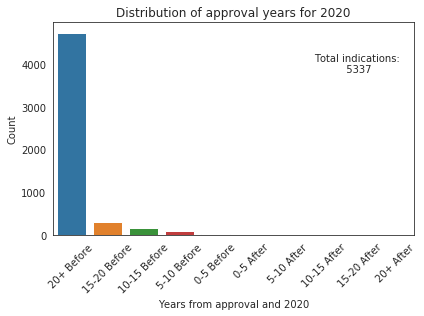

In [25]:
for year in tqdm(range(1950, 2025, 5)):

    # Define the save directory
    out_dir = os.path.join(base_dir, str(year))

    # Make sure the save directory exists, if not, make it
    try:
        os.stat(out_dir)
    except:
        os.makedirs(out_dir)       
    
    # Filter the edges by year
    e_filt = edges.query('first_pub <= @year')

    # Keep only nodes that have edges joining them
    node_ids = set(e_filt['start_id']).union(set(e_filt['end_id']))
    n_filt = nodes.query('id in @node_ids')

    # Keep only indications that have both the compound and disease still existing in the network
    ind_filt = indications.query('compound_semmed_id in @node_ids and disease_semmed_id in @node_ids').reset_index(drop=True)

    # Determine the difference between the current year and approval
    ind_filt['year_diff'] = ind_filt['approval_year'] - year
    ind_filt['year_cat'] = ind_filt['year_diff'].apply(get_year_category)

    print("Year: {}\nIDs: {:,}\nNodes: {:,}\nEdges: {:,}\nIndications: {:,}\n\n".format(
        year, len(node_ids), len(n_filt), len(e_filt), len(ind_filt)))
    
    # Save the network, indications, and summary figure
    (gt.add_colons(n_filt, id_name='cui')
       .to_csv(os.path.join(out_dir, 'nodes.csv'), index=False))
    (gt.add_colons(e_filt, col_types={'n_pmids':'INT', 'first_pub':'INT'})
       .to_csv(os.path.join(out_dir, 'edges.csv'), index=False))
    ind_filt.to_csv(os.path.join(out_dir, 'indications.csv'), index=False)
    plot_figure(ind_filt, year, out_dir);